<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Animal_Type         431 non-null    object 
 1   Breed               431 non-null    object 
 2   Age                 431 non-null    int64  
 3   Gender              431 non-null    object 
 4   Weight              431 non-null    float64
 5   Symptom_1           431 non-null    object 
 6   Symptom_2           431 non-null    object 
 7   Symptom_3           431 non-null    object 
 8   Symptom_4           431 non-null    object 
 9   Duration            431 non-null    object 
 10  Appetite_Loss       431 non-null    object 
 11  Vomiting            431 non-null    object 
 12  Diarrhea            431 non-null    object 
 13  Coughing            431 non-null    object 
 14  Labored_Breathing   431 non-null    object 
 15  Lameness            431 non-null    object 
 16  Skin_Les

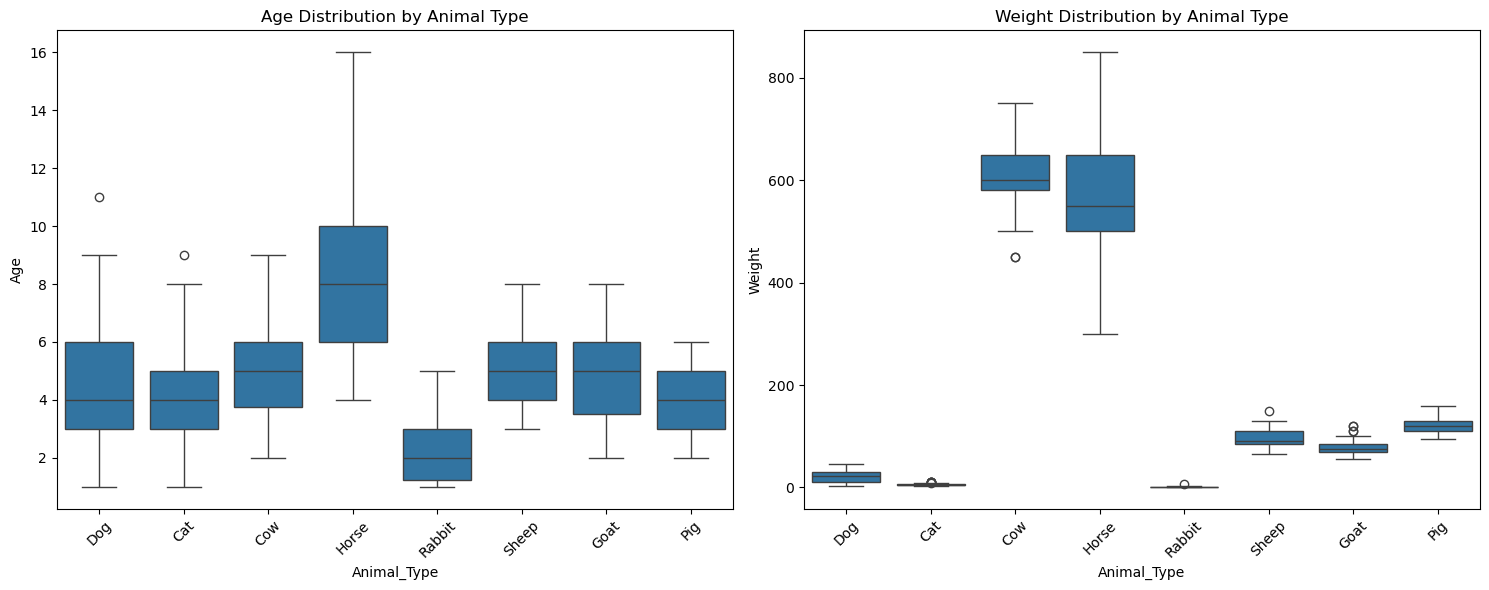

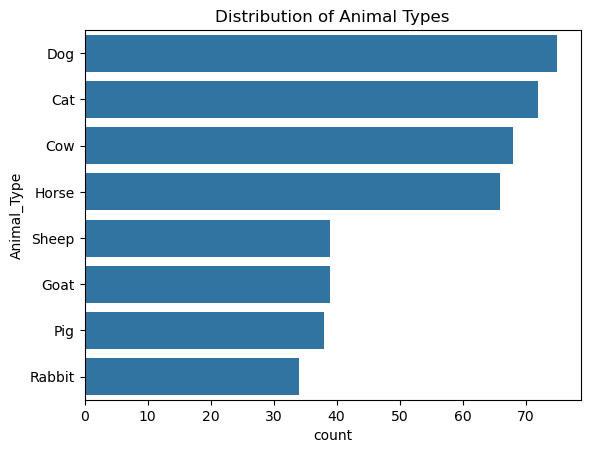

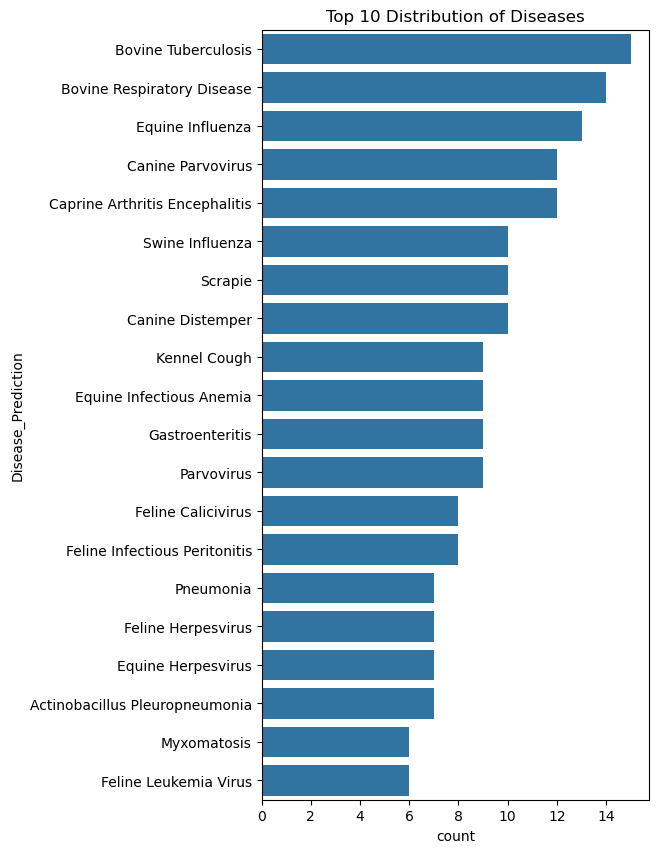

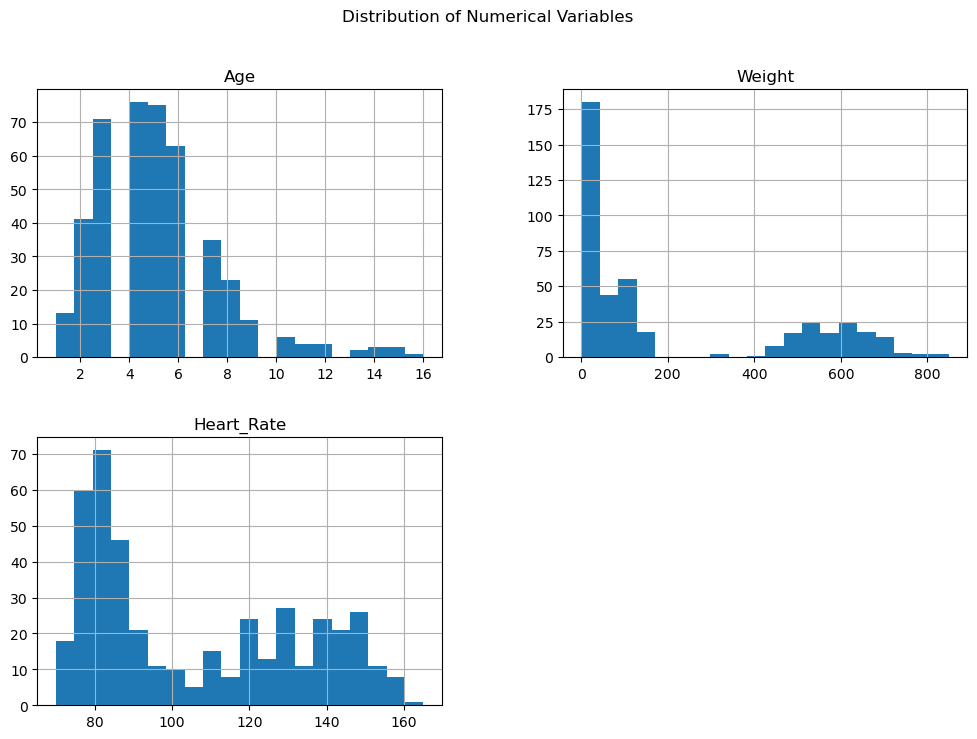

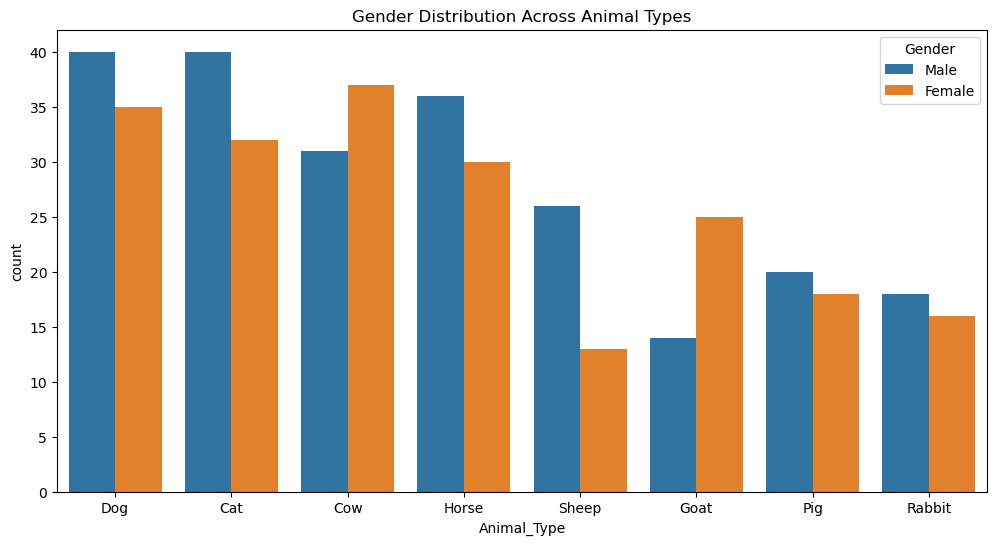

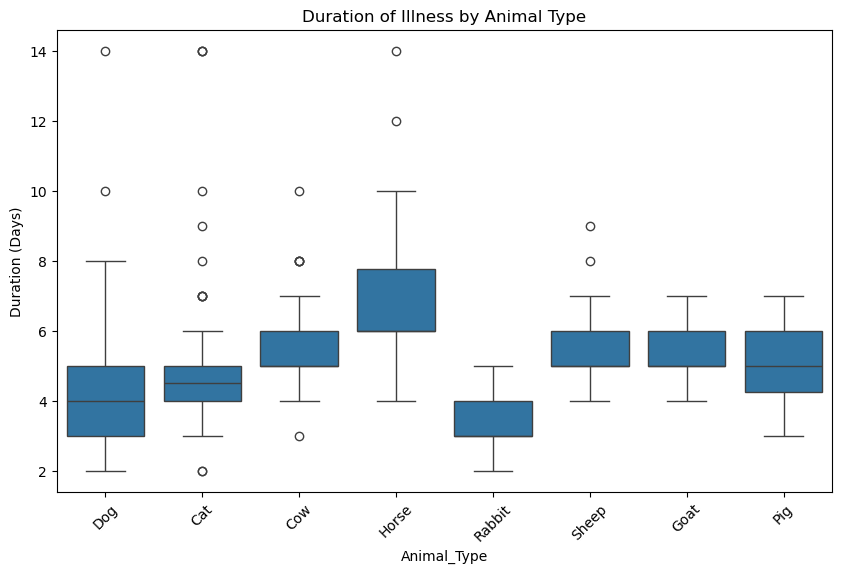

1.6.1
class dict:  {0: 'Bovine Respiratory Disease', 1: 'Bovine Tuberculosis', 2: 'Canine Distemper', 3: 'Canine Parvovirus', 4: 'Caprine Arthritis Encephalitis', 5: 'Equine Infectious Anemia', 6: 'Equine Influenza', 7: 'Gastroenteritis', 8: 'Kennel Cough', 9: 'Other', 10: 'Parvovirus', 11: 'Scrapie', 12: 'Swine Influenza'}
Class Weights: {0: 2.4055944055944054, 1: 2.2051282051282053, 2: 3.3076923076923075, 3: 2.646153846153846, 4: 2.646153846153846, 5: 3.78021978021978, 6: 2.646153846153846, 7: 3.78021978021978, 8: 3.78021978021978, 9: 0.1107177341486965, 10: 3.78021978021978, 11: 3.3076923076923075, 12: 3.3076923076923075}
Train Encoded Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Test Encoded Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Stored 'X_train' (DataFrame)
Stored 'X_test' (DataFrame)
Stored 'y_train' (Series)
Stored 'y_test' (Series)


In [2]:
%run Preprocessing.ipynb

In [3]:
# Remove constant features
constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(X_train)

# Get mask of non-constant features
non_constant_features = constant_filter.get_support()

# Filter train and test datasets
X_train = X_train.loc[:, non_constant_features]
X_test = X_test.loc[:, non_constant_features]

print(f"Removed {~non_constant_features.sum()} constant features.")


Removed -83 constant features.


In [6]:
X_train.head()

Animal_Type  Breed       Age  Gender    Weight  Appetite_Loss  Vomiting  \
146            3     62 -0.024560       0 -0.553395              1         0   
376            5     16 -0.024560       1 -0.290666              1         0   
128            6     45 -0.408585       0 -0.823465              1         0   
49             2     86  1.127516       1 -0.773624              1         0   
171            4     76  2.663617       1  1.293435              0         1   

     Diarrhea  Coughing  Labored_Breathing  ...  Duration_10 days  \
146         1         0                  0  ...             False   
376         1         1                  1  ...             False   
128         0         1                  1  ...             False   
49          1         0                  1  ...             False   
171         1         0                  1  ...             False   

     Duration_2 days  Duration_2 weeks  Duration_3 days  Duration_4 days  \
146            False             False            False            False   
376            False             False            False            False   
128            False             False             True            False   
49             False             False            False            False   
171            False             False            False            False   

     Duration_5 days  Duration_6 days  Duration_7 days  Duration_8 days  \
146            False            False             True            False   
376             True            False            False            False   
128            False            False            False            False   
49             False            False            False            False   
171             True            False            False            False   

     Duration_9 days  
146            False  
376            False  
128            False  
49             False  
171            False  

[5 rows x 82 columns]

In [4]:
# Reduce dimensions
selector = SelectKBest(f_classif, k=20)
X_train_fs = selector.fit_transform(X_train, y_train_encoded)
X_test_fs = selector.transform(X_test)


In [5]:
# Define scoring
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Base estimators
rf_base = RandomForestClassifier(
    random_state=42
)

xgb_base = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42
)

# Param grids
rf_param_dist = {
    'n_estimators': [40, 50, 60],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}
xgb_param_dist = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Random Search for RF and XGB
rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_dist,
    n_iter=8,
    scoring=f1_macro_scorer,
    cv=3,
    n_jobs=-1,
    random_state=42
)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=8,
    scoring=f1_macro_scorer,
    cv=3,
    n_jobs=-1,
    random_state=42
)

# Fit
rf_random_search.fit(X_train_fs, y_train_encoded)
xgb_random_search.fit(X_train_fs, y_train_encoded)

print("Best RF params:", rf_random_search.best_params_)
print("Best XGB params:", xgb_random_search.best_params_)


Best RF params: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 10, 'class_weight': 'balanced'}
Best XGB params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
